In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd


class MF(nn.Module):
    def __init__(self, n_coeffs, n_comps, n_pix):
        super(MF, self).__init__()
        self.cfs = nn.Parameter(torch.rand(n_coeffs, n_comps, requires_grad=True))
        self.cmps = nn.Parameter(torch.rand(n_comps, n_pix, requires_grad=True))

    def forward(self):
        return torch.matmul(self.cfs,self.cmps)


stack = np.load("stack.npy")
ncomps = 12

pca = PCA(n_components=ncomps).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print(pca_decomp.shape, stack.shape)
print(np.mean(np.square(pca_decomp - stack)))


stack_mean = np.mean(stack, axis=0)
target = torch.from_numpy(stack-stack_mean).float().to(device)
print("AAAA", torch.mean(target), torch.std(target))

ncoeffs = stack.shape[0]
npix = 160000

net = MF(ncoeffs, ncomps, npix)
net.to(device)

mse = nn.MSELoss(reduction='mean')
def unit_norm():
    torch.sum(torch.norm(net.cmps, dim=1) - torch.ones(12).to(device))
    
opt = optim.AdamW(net.parameters(), lr=1.0)
n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(epoch, loss.item())

opt = optim.AdamW(net.parameters(), lr=0.1)
n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(epoch, loss.item())

opt = optim.AdamW(net.parameters(), lr=0.01)
n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(epoch, loss.item())

opt = optim.AdamW(net.parameters(), lr=0.001)
n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(epoch, loss.item())




cuda:0
(497, 160000) (497, 160000)
5.552699592786038e-05
AAAA tensor(7.6754e-13, device='cuda:0') tensor(0.0781, device='cuda:0')
0 9.69338607788086
100 0.0005251227994449437
200 0.0001813761773519218
300 0.0001410333497915417
400 0.00010782342724269256
500 9.09696173039265e-05
600 8.24680901132524e-05
700 7.305262261070311e-05
800 6.6699183662422e-05
900 6.227974517969415e-05
0 6.114637653809041e-05
100 5.9592723118839785e-05
200 5.815305485157296e-05
300 5.6096479966072366e-05
400 5.557133772526868e-05
500 5.553209484787658e-05
600 5.552822403842583e-05
700 5.552750008064322e-05
800 5.552731818170287e-05
900 5.552994480240159e-05
0 5.5529148085042834e-05
100 5.5527096264995635e-05
200 5.5527008953504264e-05
300 5.5527008953504264e-05
400 5.552700167754665e-05
500 5.552700167754665e-05
600 5.552701622946188e-05
700 5.552700167754665e-05
800 5.5527008953504264e-05
900 5.5527034419355914e-05
0 5.552699803956784e-05
100 5.552699803956784e-05
200 5.552699803956784e-05
300 5.55269980395678

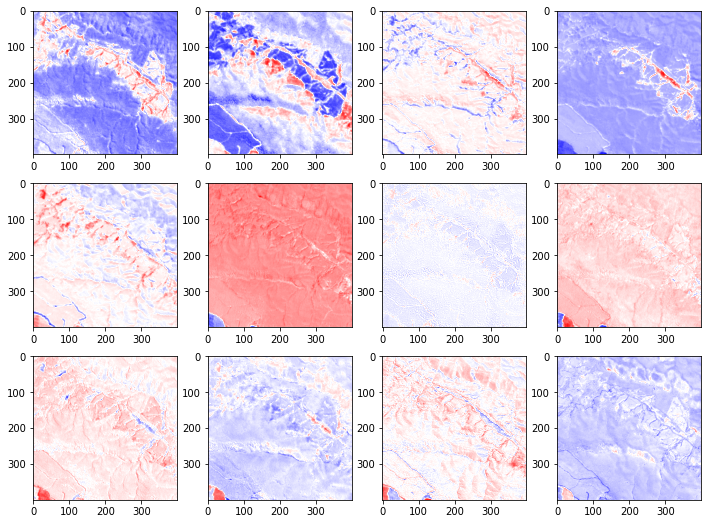

In [6]:
%matplotlib inline

pca_comps = pca.components_.reshape(12,400,400)


fig=plt.figure(figsize=(12, 9))
columns = 4
rows = 3

for i in range(12):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(pca_comps[i], cmap='bwr')

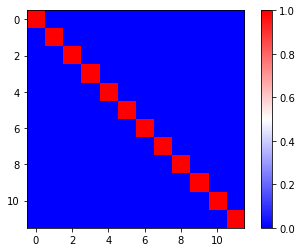

In [21]:
plt.imshow(pca.components_@pca.components_.T, cmap='bwr')
plt.colorbar()

In [29]:
torch.sum(torch.norm(net.cmps, dim=1) - torch.ones(12).to(device))

tensor(278.6743, device='cuda:0', grad_fn=<SumBackward0>)

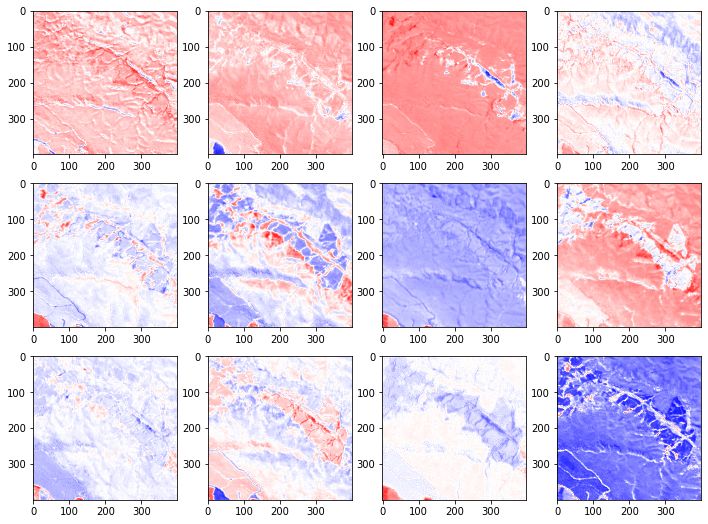

In [9]:
nn_comps = net.cmps.detach().cpu().numpy().reshape(12,400,400)


fig=plt.figure(figsize=(12, 9))
columns = 4
rows = 3

for i in range(12):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(nn_comps[i], cmap='bwr')

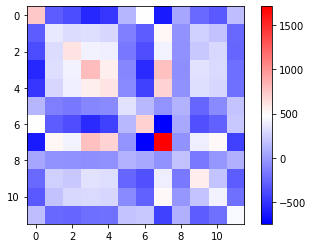

In [22]:
plt.imshow(net.cmps.detach().cpu().numpy()@net.cmps.detach().cpu().numpy().T, cmap='bwr')
plt.colorbar()